### Install relavent

In [1]:
#!pipenv install -q git+https://github.com/huggingface/transformers
#!pipenv install scikit-learn

### Data



In [9]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('./pcb defect detection/train', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('./pcb defect detection/valid/', transform=ToTensor())
test_ds  = torchvision.datasets.ImageFolder('./pcb defect detection/test/', transform=ToTensor())

AttributeError: module 'torch' has no attribute '_six'

### Training Parameters

In [10]:
EPOCHS = 1000
BATCH_SIZE = 10
LEARNING_RATE = 2e-5    

### Setup MovileNet

In [15]:
import torch.nn as nn
import torch
"""
Source: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/
"""
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)

#  Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda()

device

Using cache found in /home/ying/.cache/torch/hub/pytorch_vision_v0.10.0


device(type='cuda')

### Train

In [69]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import ViTFeatureExtractor
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4,drop_last=True)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last=True) 


# Train
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):

    # fetch every individual in batch 
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)

    # recover to batch after processing by feature extractor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))

    # apply to gpu
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)
    b_y = Variable(y)

    # forword
    # output, loss = model(b_x, None)No module named 'sklearn'
    output, loss = model(b_x, None)

    # train loss
    loss = loss_func(output, b_y)   
    optimizer.zero_grad()           
    loss.backward()                 
    optimizer.step()


    # Test
    if step % 50 == 0:

      # iter next batch for testing
      test = next(iter(test_loader))
      test_x = test[0]

      # reshape
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))

      # apply to gpu
      test_x = test_x.to(device)
      test_y = test[1].to(device)

      # compare test output
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)

      # test accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Number of train samples:  485
Number of test samples:  69
Detected Classes are:  {'Missing_hole': 0, 'Mouse_bite': 1, 'Open_circuit': 2, 'Short': 3, 'Spur': 4, 'Spurious_copper': 5}


Epoch:  0 | train loss: 1.7778 | test accuracy: 0.10
Epoch:  1 | train loss: 1.7711 | test accuracy: 0.20
Epoch:  2 | train loss: 1.7837 | test accuracy: 0.20
Epoch:  3 | train loss: 1.8062 | test accuracy: 0.20
Epoch:  4 | train loss: 1.7929 | test accuracy: 0.20
Epoch:  5 | train loss: 1.8110 | test accuracy: 0.10
Epoch:  6 | train loss: 1.8080 | test accuracy: 0.10
Epoch:  7 | train loss: 1.8007 | test accuracy: 0.10
Epoch:  8 | train loss: 1.8252 | test accuracy: 0.10
Epoch:  9 | train loss: 1.8165 | test accuracy: 0.00
Epoch:  10 | train loss: 1.7815 | test accuracy: 0.20
Epoch:  11 | train loss: 1.7901 | test accuracy: 0.10
Epoch:  12 | train loss: 1.7891 | test accuracy: 0.10
Epoch:  13 | train loss: 1.8411 | test accuracy: 0.00
Epoch:  14 | train loss: 1.8301 | test accuracy: 0.00
Epoch:  15 | train loss: 1.8207 | test accuracy: 0.00
Epoch:  16 | train loss: 1.8439 | test accuracy: 0.10
Epoch:  17 | train loss: 1.8228 | test accuracy: 0.10
Epoch:  18 | train loss: 1.8054 | test

### Evaluate

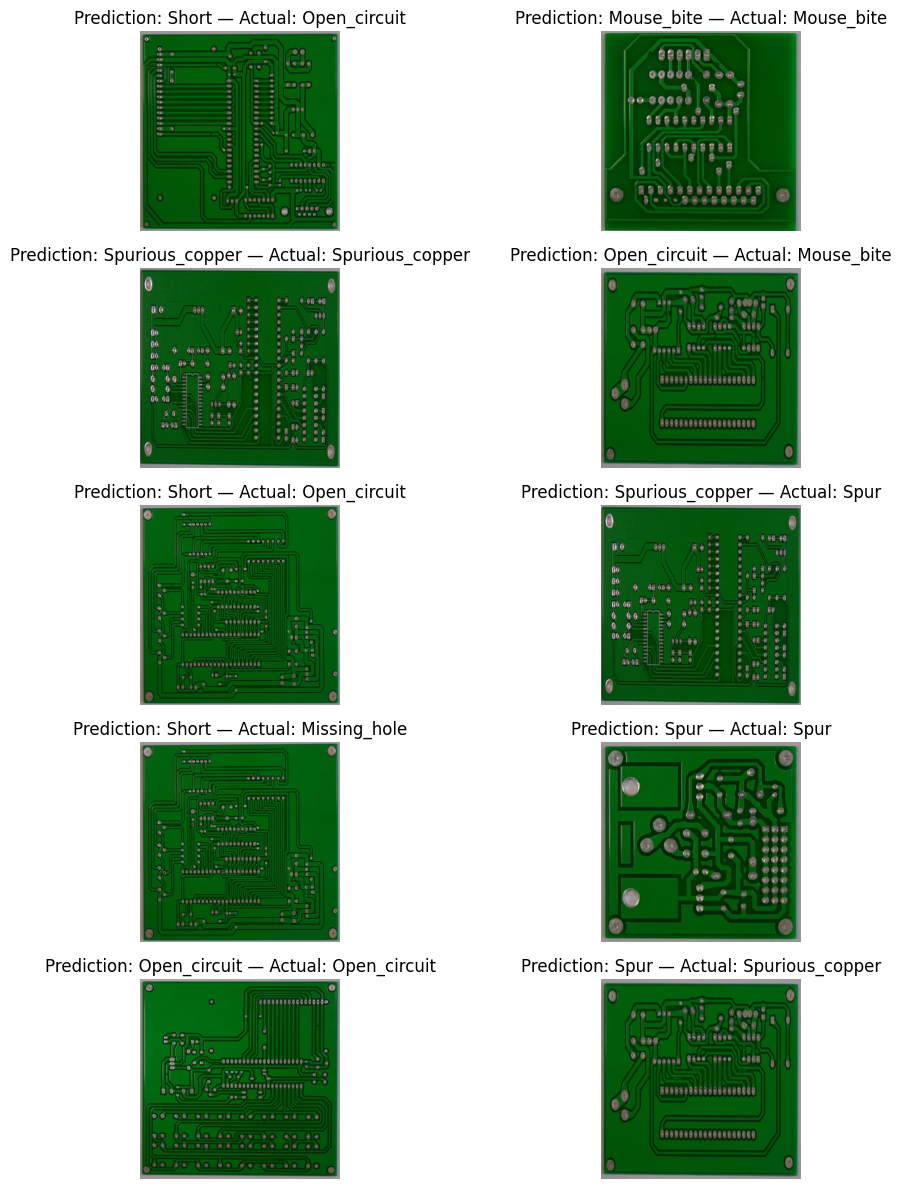

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import torch

EVAL_BATCH = len(valid_ds)
eval_loader = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4,drop_last=True)


# Disable grad
with torch.no_grad():
    # 取得批次資料
    inputs, targets = next(iter(eval_loader))
    # 初始化儲存預測與實際的列表No module named 'sklearn'
    predicted_classes = []
    target_classes = []

    # 儲存原始輸入影像
    original_inputs = inputs.clone().permute(0, 2, 3, 1).cpu().numpy()

    # Preprocess
    processed_inputs = []
    for batch_index, input_image in enumerate(inputs):
        input_image = input_image.permute(1, 2, 0).numpy()
        processed = np.squeeze(input_image)
        processed = torch.tensor(feature_extractor(processed)['pixel_values'][0])
        processed_inputs.append(processed)

    # Stack as batch
    inputs = torch.stack(processed_inputs).to(device)
    targets = targets.to(device)

    # Predict
    predictions, losses = model(inputs, targets)
    predicted_classes = predictions.cpu().argmax(dim=1).tolist()
    target_classes = targets.cpu().tolist()

    # Display
    plt.figure(figsize=(12, 12))
    for i in range(10):
        plt.subplot(5, 2, i + 1)
        plt.imshow(original_inputs[i])
        plt.title(
            f"Prediction: {list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_classes[i])]} — "
            f"Actual: {list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target_classes[i])]}"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()




### Indicator

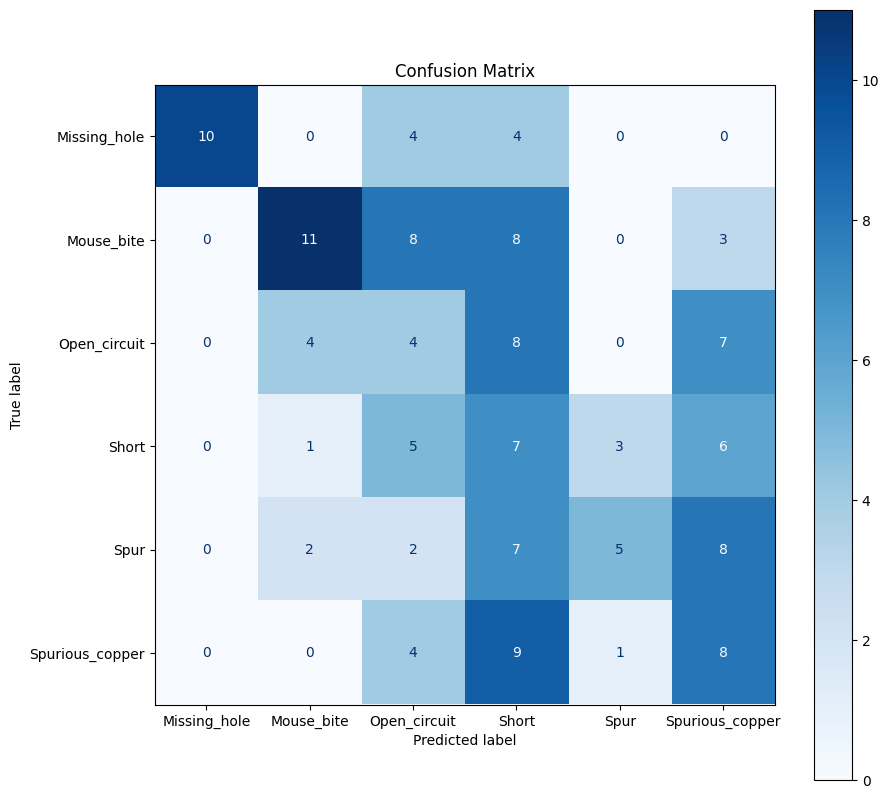

Precision: 0.4546
Recall: 0.3310
F1-score: 0.3579
mAP: 0.2900

Classification Report:
                  precision    recall  f1-score   support

   Missing_hole       1.00      0.56      0.71        18
     Mouse_bite       0.61      0.37      0.46        30
   Open_circuit       0.15      0.17      0.16        23
          Short       0.16      0.32      0.22        22
           Spur       0.56      0.21      0.30        24
Spurious_copper       0.25      0.36      0.30        22

       accuracy                           0.32       139
      macro avg       0.45      0.33      0.36       139
   weighted avg       0.45      0.32      0.35       139



In [73]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, classification_report, ConfusionMatrixDisplay
"""
classification_report

    col
        precision : TP / (TP+FP)
        recall    : TP / (TP+FN)
        F1-score  : 2*precision*recall / (precision + recall)
        support   : number of samples.

    row
        accuracy     : (TP + TN) / All
        macro avg    : Unweighted average of an indicator.
        weighted avg : Weighted average of an indicator by support.

"""

# Confusion matrix
class_names = list(valid_ds.class_to_idx.keys())
cm = confusion_matrix(target_classes, predicted_classes, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

fig = disp.ax_.get_figure()     # Adjust size
fig.set_figwidth(10)
fig.set_figheight(10)  

plt.title("Confusion Matrix")   # plot
plt.show()


# Precision, Recall, F1-score
precision = precision_score(target_classes, predicted_classes, average='macro')
recall    = recall_score(target_classes, predicted_classes, average='macro')
f1        = f1_score(target_classes, predicted_classes, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# mAP
binary_targets      = np.eye(len(class_names))[target_classes]
binary_predictions  = np.eye(len(class_names))[predicted_classes]
mAP = average_precision_score(binary_targets, binary_predictions, average='macro')
print(f"mAP: {mAP:.4f}")

# Display Report
report = classification_report(target_classes, predicted_classes, target_names=class_names)
print("\nClassification Report:\n", report)

### Save Model


In [74]:
torch.save(model, './content/model.pt')

## Use your Exported Model

In [75]:
MODEL_PATH = './content/model.pt'
model = torch.load(MODEL_PATH)
model.eval()

/tmp/ipykernel_33232/2976210292.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe